In [78]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [48]:
os.chdir(r"C:\Users\jerep\OneDrive\Documents\thesis\master_thesis\data")

df = pd.read_csv("2010_rolling_window.csv")
df

,time_stamp,highlighted,quantity,rolling_average_quantity,rolling_sd_quantity,z_score_quantity,no_bidders,rolling_average_no_bidders,rolling_sd_no_bidders,z_score_no_bidders
0,2010-01-01 01:00:00,False,2492.582,NaN,NaN,NaN,98,NaN,NaN,NaN
1,2010-01-01 02:00:00,False,2526.076,NaN,NaN,NaN,98,NaN,NaN,NaN
2,2010-01-01 03:00:00,False,2495.420,NaN,NaN,NaN,98,NaN,NaN,NaN
3,2010-01-01 04:00:00,False,2366.329,NaN,NaN,NaN,98,NaN,NaN,NaN
4,2010-01-01 05:00:00,False,2352.472,NaN,NaN,NaN,98,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8754,2010-12-31 20:00:00,False,1663.168,NaN,NaN,NaN,84,NaN,NaN,NaN
8755,2010-12-31 21:00:00,False,2087.396,NaN,NaN,NaN,89,NaN,NaN,NaN
8756,2010-12-31 22:00:00,False,2075.185,NaN,NaN,NaN,86,NaN,NaN,NaN
8757,2010-12-31 23:00:00,False,1963.604,NaN,NaN,NaN,83,NaN,NaN,NaN


In [50]:
df["collusion"] = df["highlighted"].astype(int)

# remove NaNs from our moving average z_scores
df.dropna(subset=['z_score_quantity', "z_score_no_bidders"], inplace=True)

X = df[["z_score_quantity", "z_score_no_bidders"]]
y = df["collusion"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
C = 1.0
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

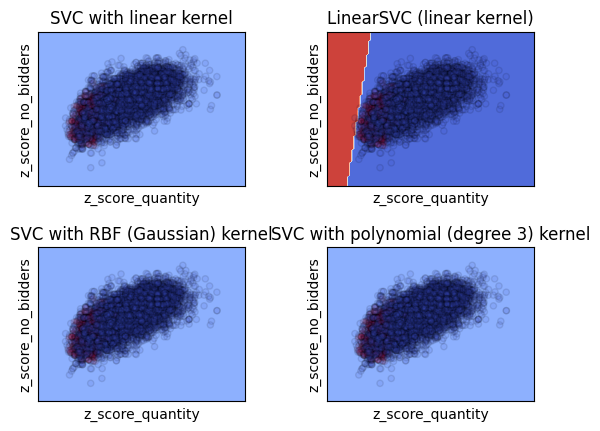

In [39]:
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF (Gaussian) kernel",
    "SVC with polynomial (degree 3) kernel",
)
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        ax=ax,
        xlabel="z_score_quantity",
        ylabel="z_score_no_bidders",
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k", alpha=0.1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

there is too much weight on the blue observations (non-collusive) because there are too many of them. Let's assign a much higher weight for the reds.

In [40]:
class_weights = {0: 1, 1: 10}

In [41]:
C = 1.0
models = (
    svm.SVC(kernel="linear", C=C, class_weight=class_weights),
    svm.LinearSVC(C=C, max_iter=10000, class_weight=class_weights),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, class_weight=class_weights),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, class_weight=class_weights),
)
models = (clf.fit(X, y) for clf in models)

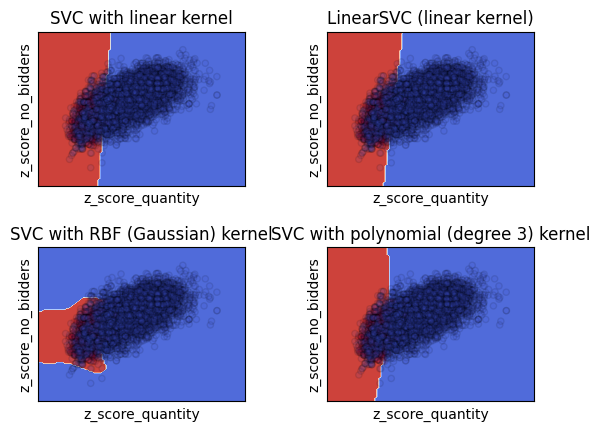

In [42]:
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF (Gaussian) kernel",
    "SVC with polynomial (degree 3) kernel",
)
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        ax=ax,
        xlabel="z_score_quantity",
        ylabel="z_score_no_bidders",
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k", alpha=0.1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

Gaussian finally performs a bit better (with a high chance of overfitting though).

In [7]:
# Define Bayesian search space
param_space = {
    'C': Real(0.01, 1, prior='uniform'),  # Continuous range for C
    'gamma': Real(0.001, 10, prior='log-uniform')  # Log scale for gamma
}

# Initialize SVM with RBF kernel
svm_rbf = svm.SVC(kernel='rbf', class_weight=class_weights)

# Bayesian Optimization
bayes_search = BayesSearchCV(
    svm_rbf, 
    param_space,
    n_iter=50,
    scoring='recall', # prioritizes true positives
    cv=5,
    n_jobs=-1,
    verbose=1
)
bayes_search.fit(X, y)

# Best results
print("Best parameters:", bayes_search.best_params_)
print("Best recall score:", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

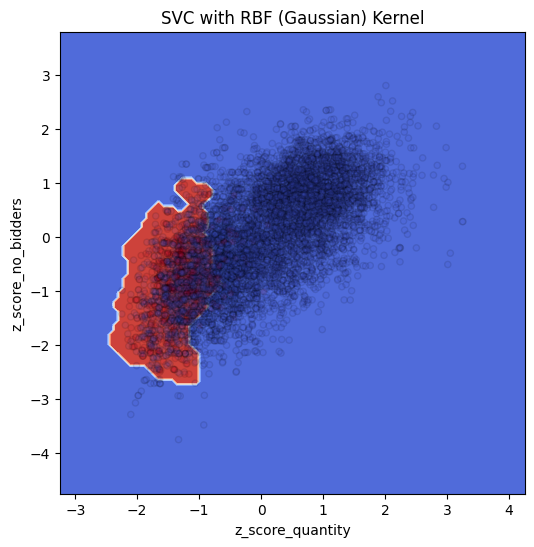

In [43]:
optimal_svm = svm.SVC(kernel="rbf", gamma=bayes_search.best_params_["gamma"], C=bayes_search.best_params_["C"], class_weight=class_weights)

model = optimal_svm.fit(X, y)

fig, ax = plt.subplots(figsize=(6, 6))

# Extract first two features for plotting
X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    optimal_svm,
    X,
    response_method="predict",
    cmap=plt.cm.coolwarm,
    ax=ax,
    xlabel="z_score_quantity",
    ylabel="z_score_no_bidders",
)

# Scatter plot of data points
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k", alpha=0.1)

# Set the title
ax.set_title("SVC with RBF (Gaussian) Kernel")

# Show the plot
plt.show()

In [9]:
# Define Bayesian search space
param_space = {
    'C': Real(0.01, 1, prior='uniform'),  # Continuous range for C
    'gamma': Real(0.001, 10, prior='log-uniform')  # Log scale for gamma
}

# Initialize SVM with RBF kernel
svm_rbf = svm.SVC(kernel='rbf')

# Bayesian Optimization
bayes_search = BayesSearchCV(
    svm_rbf, 
    param_space,
    n_iter=50,
    scoring='recall', # prioritizes true positives
    cv=5,
    n_jobs=-1,
    verbose=1
)
bayes_search.fit(X, y)

# Best results
print("Best parameters:", bayes_search.best_params_)
print("Best recall score:", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

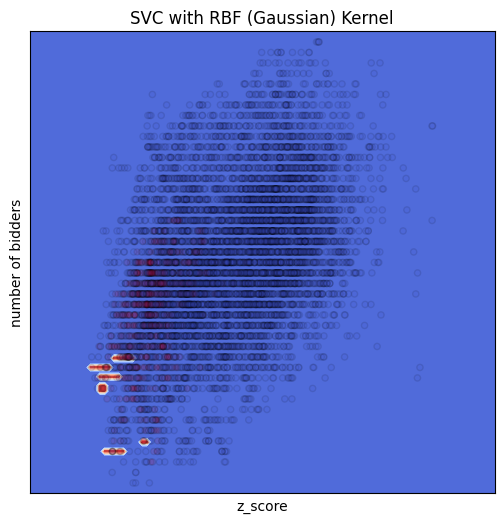

In [10]:
optimal_svm = svm.SVC(kernel="rbf", gamma=10, C=0.9538)

model = optimal_svm.fit(X, y)

fig, ax = plt.subplots(figsize=(6, 6))

# Extract first two features for plotting
X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    optimal_svm,
    X,
    response_method="predict",
    cmap=plt.cm.coolwarm,
    ax=ax,
    xlabel="z_score_quantity",
    ylabel="z_score_no_bidders",
)

# Scatter plot of data points
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k", alpha=0.1)

# Remove ticks for cleaner visualization
ax.set_xticks(())
ax.set_yticks(())

# Set the title
ax.set_title("SVC with RBF (Gaussian) Kernel")

# Show the plot
plt.show()

Let's simply use the model we have and see how many observations we keep and recall score.

In [44]:
df["predicted"] = model.predict(df[["z_score_quantity", "z_score_no_bidders"]])

In [45]:
print("Percentage of kept observations:")
sum(df["predicted"])/len(df)

Percentage of kept observations:


0.2376629422718808

In [46]:
print("Recall:")
sum(df.loc[df["highlighted"] == 1, "predicted"]) / sum(df["highlighted"]==1)

Recall:


0.8958333333333334

# One-Class SVM with Quantity as Feature

In [65]:
X = df[["z_score_quantity", "z_score_no_bidders", "quantity"]]
y = df["collusion"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
# The most important hyperparameter for one-class SVM is nu, the approximate fraction of novelties
clf = svm.OneClassSVM(nu=0.1, kernel="rbf")
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


# Mapping is necessary to convert the numpy array of -1s (novelties) and 1s (non-novelties) into 1s and 0s
mapping = {-1:1, 1:0}
y_pred_train = np.vectorize(mapping.get)(y_pred_train)
y_pred_test = np.vectorize(mapping.get)(y_pred_test)

In [67]:
accuracy_train = sum(y_pred_train==y_train)/len(y_train)
accuracy_test = sum(y_pred_test==y_test)/len(y_test)

recall_train = sum((y_pred_train*y_train)==1)/sum(y_train)
recall_test = sum((y_pred_test*y_test)==1)/sum(y_test)

print(f"""Accuracy in the train set: {accuracy_train}, Recall in the train set: {recall_train} \n
      Accuracy in the test set: {accuracy_train}, Recall in the test set: {recall_test}""")

Accuracy in the train set: 0.8659217877094972, Recall in the train set: 0.2441860465116279 

      Accuracy in the test set: 0.8659217877094972, Recall in the test set: 0.273972602739726


Let's try to optimize this by finding a good nu

In [79]:
def one_class_svm_performance(trial_nu, trial_X_train, trial_X_test, trial_y_test):
    clf = svm.OneClassSVM(nu=trial_nu, kernel="rbf")
    clf.fit(trial_X_train)

    y_pred_test = clf.predict(trial_X_test)

    # Mapping is necessary to convert the numpy array of -1s (novelties) and 1s (non-novelties) into 1s and 0s
    mapping = {-1:1, 1:0}
    y_pred_test = np.vectorize(mapping.get)(y_pred_test)
    accuracy = sum(y_pred_test==trial_y_test)/len(trial_y_test)
    recall = sum((y_pred_test*trial_y_test)==1)/sum(trial_y_test)
    return accuracy, recall

nus = np.arange(0.01,0.99, 0.01)
accuracies = []
recalls = []

for nu in tqdm(nus):
    current_accuracy, current_recall = one_class_svm_performance(nu, X_train, X_test, y_test)
    accuracies.append(current_accuracy)
    recalls.append(current_recall)

100%|██████████| 98/98 [04:58<00:00,  3.05s/it]


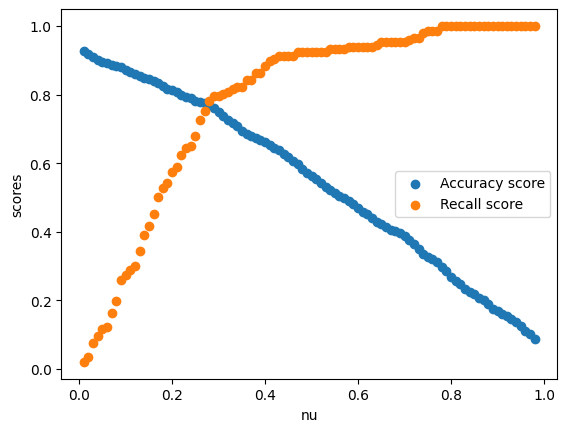

In [85]:
plt.scatter(nus, accuracies, label="Accuracy score")
plt.scatter(nus, recalls, label="Recall score")
plt.xlabel("nu")
plt.ylabel("scores")
plt.legend()
plt.show()

Beautiful elbow at around nu=0.3 where the accuracy/recall score tradeoff becomes less useful. At this point, we correctly flag about 80% of cartels and correctly predict 80% of all observations. A second elbow occurs at around nu=0.4 where we begin to flag many observations, correctly flagging about 90% of cartel cases but only correctly predicting about 60% of all cases.

While we cannot expect this simple novelty detection to model cartels, we can be a little aggressive by overpredicting and get most of our cartel instances. Let's use that!

# 2016

In [87]:
df2 = pd.read_csv("2010_rolling_window.csv")

df2["collusion"] = df2["highlighted"].astype(int)

# remove NaNs from our moving average z_scores
df2.dropna(subset=['z_score_quantity', "z_score_no_bidders"], inplace=True)

X = df2[["z_score_quantity", "z_score_no_bidders", "quantity"]]
y = df2["collusion"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
optimal_svm = one_class_svm_performance(0.4, X_train, X_test, y_test)
print(f"Accuracy